# **Previsão de cancelamento - Hotelaria**

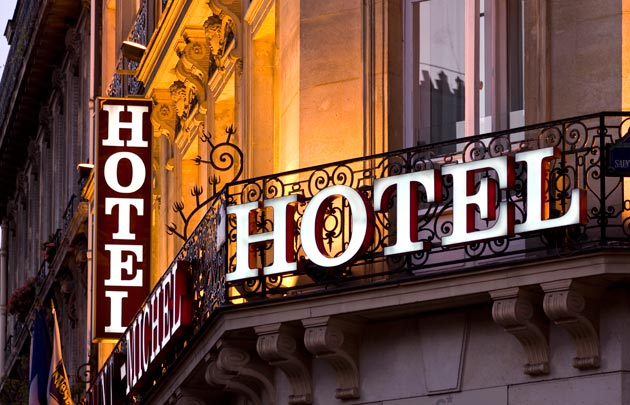

Um dos maiores problemas que a indústria hoteleira enfrenta é a alta taxa de cancelamento de reservas,uma vez que o cancelamento repentino resulta em quartos não vendidos, levando à perda direta de receita e à dificuldade na gestão da ocupação dos quartos. Além disso,leva a custos operacionais desnecessários, como desperdício de alimentos, produtos de limpeza e outros recursos, pois os hotéis precisam preparar os quartos, manter a equipe de funcionários e oferecer serviços de acordo com o número de reservas esperadas.. o que causa impactos financeiros significativos para o hotel.
Nesse cenário, esse projeto visa fazer uma previsão de cancelamento de reservas com base em dados históricos e modelos de aprendizado de máquina , permitindo que os hotéis identifiquem antecipadamente reservas com maior risco de cancelamento. Com essa previsão, a equipe de gestão pode adotar abordagens proativas, como promoções personalizadas, políticas de cancelamento flexíveis e melhorias no atendimento ao cliente, a fim de reduzir o índice de cancelamento e otimizar a ocupação, melhorando a eficiência operacional e a *saúde financeira* do hotel.

# Aquisição dos dados

 O *dataset* utilizado conta com de cerca de 119.000 registros com dados históricos de reservas de uma rede hoteleira, com informações como quando a reserva foi feita, duração da estadia, número de adultos, crianças e/ou bebês, entre outras coisas.. Os dados foram disponibilizados no Kaggle já traduzidos e podem ser encontrados [neste link](http://www.kaggle.com/datasets/datacertlaboratoria/projeto-4).Os dados foram originalmente retirados do artigo *'Hotel Booking Demand Datasets', escrito por Nuno Antonio, Ana Almeida e Luis Nunes para Data in Brief, Volume 22, fevereiro de 2019*.
 

# Importando as bibliotecas


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, f1_score,average_precision_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from sklearn.ensemble import IsolationForest
from skopt.space import Integer, Real, Categorical
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('/kaggle/input/projeto-4/hotel_bookings.csv')
pd.set_option('display.max_columns',None)
pd.options.plotting.backend = "plotly"
colors = ['royalblue','midnightblue']


In [4]:
df.shape

(119390, 31)

# **Análise exploratória**

In [5]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


Por meio do método describe(), verificamos o resumo estatístico do DataFrame, nele é possível identificar:
* *Variáveis com sua média e mediana bastante discreprantes*
* *Variáveis com valor máximo muito discrepante do 75º percentil* 
* *Variáveis com desvio padrão(std) muito alto*

Essa breve análise já indica a presença de muitos outliers no DataFrame, e que podem ser confirmados ao visualizar o BoxPlot das variáveis abaixo: 

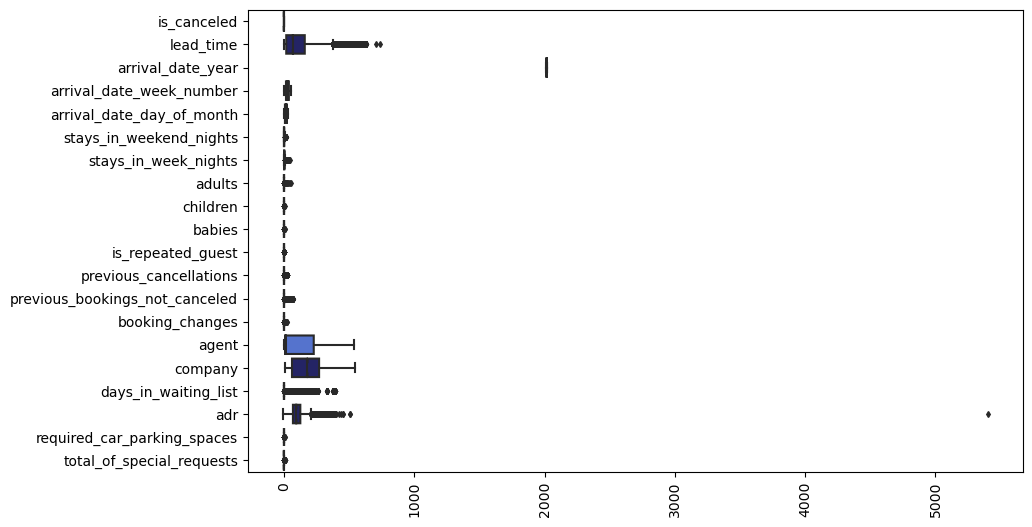

In [6]:
# plotando boxplot das variáveis numéricas
# Configura o tamanho do gráfico
plt.figure(figsize=(10,6))

# Cria o boxplot ajustado
sns.boxplot(data=df, orient="h", palette=colors, notch=True, linewidth=1.5, fliersize=3)

# Exibe o gráfico

plt.xticks(rotation=90)
plt.show()

*O BoxPlot confirma a presença de muitos outliers no nosso DataFrame, no entanto eles podem ser importantes para captar algum comportamento incomum dos clientes, e por isso não vão ser removidos de imediato. Nesse projeto os outliers vão ser tratados apenas na etapa de pré-processamento dos dados, com uma detecção de anomalias e com a escolha de padronizadores e modelos menos sensíveis à presença desses outliers(ex:RobustScaler e modelos de árvores).*

# Analisando as características das reservas:

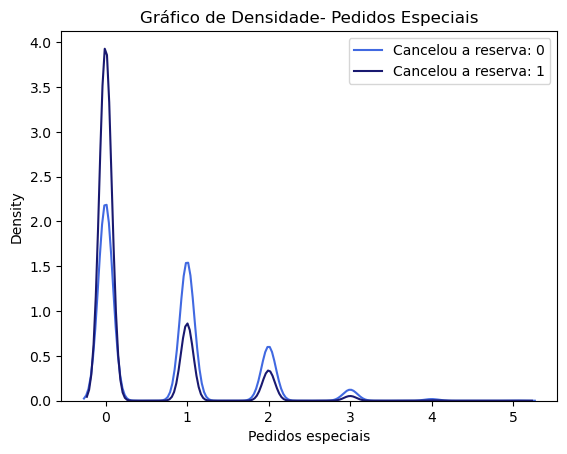

In [7]:
#plotando gráfico dos pedidos especiais relacionado com a taxa de cancelamento
churn_values = [0,1]
for churn_value in churn_values:
    sns.kdeplot(df[df['is_canceled'] == churn_value]['total_of_special_requests'], label=f'Cancelou a reserva: {churn_value}',color=colors[churn_value])
    
plt.xlabel('Pedidos especiais')
plt.ylabel('Density')
plt.title('Gráfico de Densidade- Pedidos Especiais')
plt.legend()

   **Observa-se no gráfico que:**
1. Há uma densidade maior de reservas canceladas quando não há nenhum pedido especial de reserva.


Text(0.5, 1.0, 'Tempo Reservas - Canceladas')

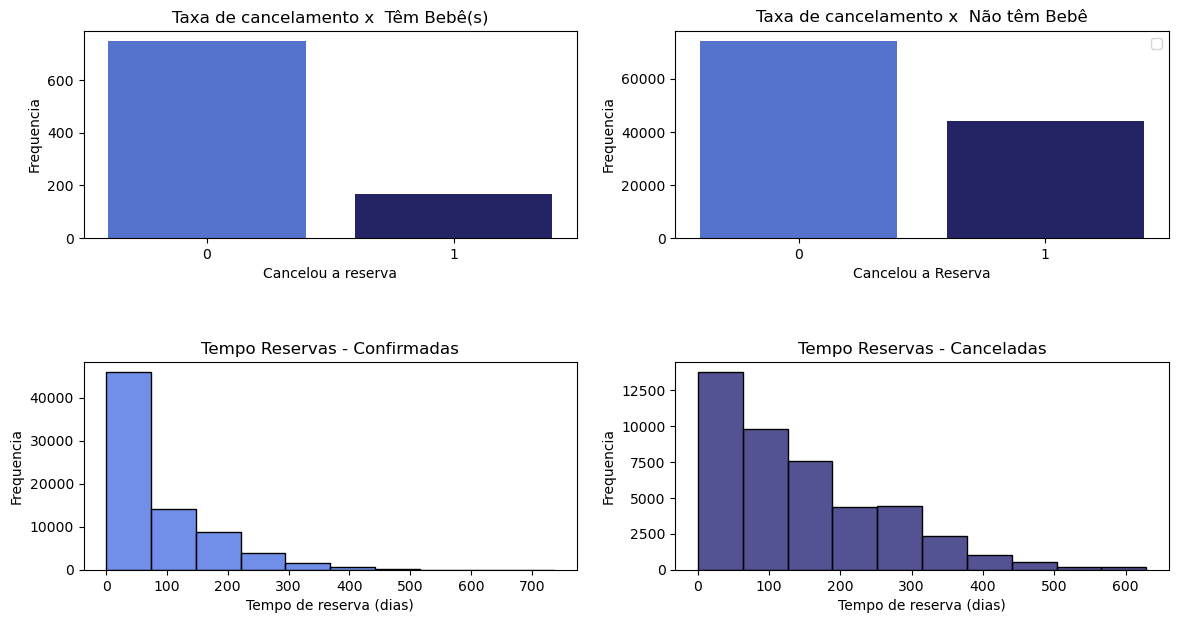

In [8]:

#plotando graficos comparativo entre a taxa de cancelamento em reservas com bebê x sem bebê
fig, ax = plt.subplots(1, 2, figsize = (14, 7))
fig.subplots_adjust(hspace=0.6)

plt.subplot(2, 2, 1)
sns.countplot(data=df,x=df[df['babies']!=0].is_canceled,palette=colors, label='Cancelou a reserva: 1')
plt.xlabel('Cancelou a reserva')
plt.ylabel('Frequencia')
plt.title('Taxa de cancelamento x  Têm Bebê(s)')



plt.subplot(2, 2, 2)
sns.countplot(data=df,x=df[df['babies']==0].is_canceled,palette=colors)
plt.xlabel('Cancelou a Reserva')
plt.ylabel('Frequencia')
plt.title('Taxa de cancelamento x  Não têm Bebê')
plt.legend()


#plotando graficos do tempo entre a reserva até a chegada em reservas canceladas x concluidas 
plt.subplot(2, 2, 3)
sns.histplot(data=df,x=df[df['is_canceled']==0].lead_time,bins=10,color=colors[0])
plt.xlabel('Tempo de reserva (dias)')
plt.ylabel('Frequencia')
plt.title('Tempo Reservas - Confirmadas')

plt.subplot(2, 2, 4)
sns.histplot(data=df,x=df[df['is_canceled']==1].lead_time,bins=10,color=colors[1])
plt.xlabel('Tempo de reserva (dias)')
plt.ylabel('Frequencia')
plt.title('Tempo Reservas - Canceladas')




**Analisando os gráficos, podemos fazer algumas conclusões:**
* As reservas que incluem bebês têm menor risco de cancelamento. 
* As reservas feitas com mais antecedência correm maior risco de cancelamento.

In [9]:
# Comparando algumas features numéricas interessantes com a variável alvo
lista_num=['previous_cancellations','previous_bookings_not_canceled','days_in_waiting_list','adr']
correlacao= df[lista_num].corrwith(df['is_canceled'])
correlacao=pd.DataFrame(correlacao)
correlacao

,0
previous_cancellations,0.110133
previous_bookings_not_canceled,-0.057358
days_in_waiting_list,0.054186
adr,0.047557


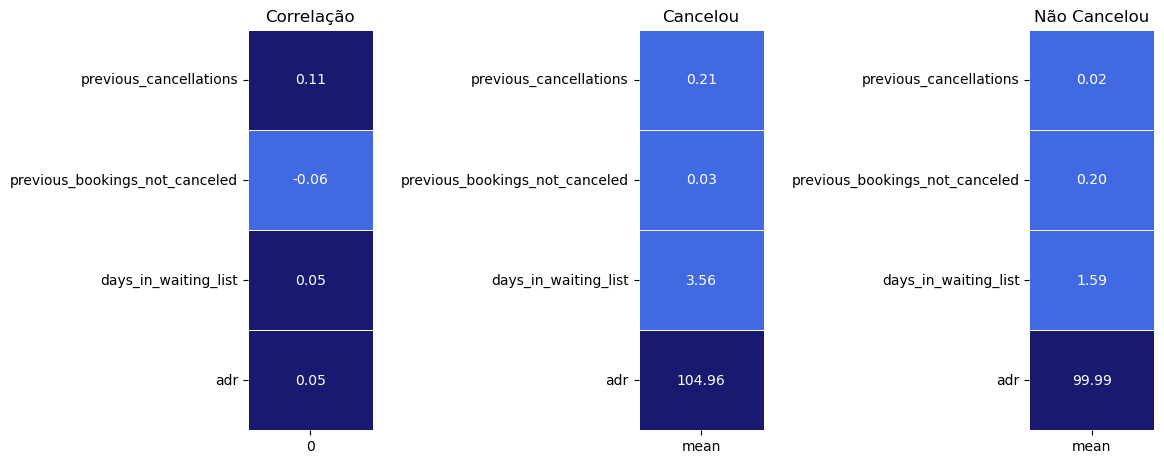

In [10]:
# Criando gráfico comparativo entre algumas features numéricas com a variável alvo
fig = plt.figure(figsize = (12, 5))

# Grid com 1 linha e 3 colunas
gs = fig.add_gridspec(1, 3)

plt.subplot(gs[0, 0])
sns.heatmap(correlacao, annot = True, cmap = colors ,linewidths = 0.4 ,cbar = False, fmt = '.2f',)
plt.title('Correlação')

plt.subplot(gs[0, 1])
sns.heatmap(df[lista_num][df['is_canceled'] == 1].describe().T[["mean"]], annot = True, cmap = colors, linewidths = 0.4, cbar = False, fmt = '.2f')
plt.title('Cancelou')

plt.subplot(gs[0, 2])
sns.heatmap(df[lista_num][df['is_canceled'] == 0].describe().T[["mean"]], annot = True, cmap = colors, linewidths = 0.4, cbar = False, fmt = '.2f')
plt.title('Não Cancelou')

fig.tight_layout(pad = 2)

plt.show()

**Note alguns fatos interessantes, retirados dos dados estatísticos:**
* O preço da diária(adr) é um fator de risco relevante, sendo mais cara em reservas canceladas.
* O histórico de reservas concluídas do usuário é um fator importante para determinar o risco de novo cancelamento.
* Assim como em reservas concluídas, o histórico de reservas anteriores canceladas também influencia no risco.

0    75166
1    44224
Name: is_canceled, dtype: int64

Reservas canceladas representam 37.04% do dataset.



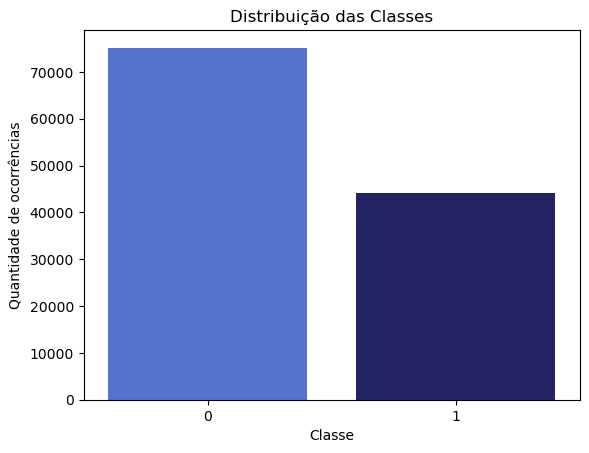

In [11]:
#Analisando o balanceamento de Classes
print(df['is_canceled'].value_counts())
print('\nReservas canceladas representam {:.2f}% do dataset.\n'.format((df[df.is_canceled == 1].shape[0] / df.shape[0]) * 100))

# Plotando gráfico de barras para as Classes
sns.countplot(data=df,x='is_canceled',palette=colors);
plt.title('Distribuição das Classes')
plt.ylabel('Quantidade de ocorrências')
plt.xlabel('Classe')
plt.show();

Note que as reservas canceladas representam cerca de 27,49% apenas do DataFrame, para evitar que o modelo fique enviesado, trataremos disso também na etapa de preparação dos dados.

# **Preparação dos dados:**

In [12]:
df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/07/15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1/07/15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2/07/15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2/07/15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/07/15
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,240.0,NaN,0,Transient,98.0,0,1,Check-Out,3/07/15
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,NaN,NaN,0,Transient,107.0,0,0,Check-Out,3/07/15
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,303.0,NaN,0,Transient,103.0,0,1,Check-Out,3/07/15
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,240.0,NaN,0,Transient,82.0,0,1,Canceled,6/05/15
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,15.0,NaN,0,Transient,105.5,0,0,Canceled,22/04/15


In [13]:
#checagem de valores nulos
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
agent                              16340
company                           112593
days_in_waiting_

Algumas features não serão usadas no nosso modelo,como 'company' por ter mais de 90% de valores ausentes, e os 'reservation_status' pois dizem a mesma coisa que nossa variável dependente.

In [14]:
#dropando features indesejáveis
df.drop('company',axis=1,inplace=True)
df.drop('reservation_status',axis=1,inplace=True)
df.drop('reservation_status_date',axis=1,inplace=True)



No método describe() é possível visualizar que há valores negativos para feature de preço da diária(adr), apesar de também ser uma anomalia, esses se caracterizam como um erro de registro, e portando devem ser removidos

In [15]:
#removendo os valores negativos da feature 'adr'
neg_values = df.loc[df['adr'] <= 0]
df=df.drop(neg_values.index)

Para substituir os valores ausentes das outras features usaremos o valor mais frequente(moda),foi o método escolhido por se tratarem apenas de variáveis categóricas e discretas. 

In [16]:
moda=df['country'].mode()[0]
moda_crianca=df['children'].mode()[0]
df['country'].fillna(moda,inplace=True)
df['children'].fillna(moda_crianca,inplace=True)
df['agent'].fillna(0,inplace=True)
df.isnull().sum()


hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

# Separando variáveis Numéricas e Categóricas

In [17]:
categoricos=[]
numericos=[]
for features in df.columns:
    if df[features].dtype== object:
        categoricos.append(features)
    else:
        numericos.append(features)
df[categoricos].head(23)

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,customer_type
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,Transient
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,Transient
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,Transient
5,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,Transient
6,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,Transient
7,Resort Hotel,July,FB,PRT,Direct,Direct,C,C,Transient
8,Resort Hotel,July,BB,PRT,Online TA,TA/TO,A,A,Transient
9,Resort Hotel,July,HB,PRT,Offline TA/TO,TA/TO,D,D,Transient
10,Resort Hotel,July,BB,PRT,Online TA,TA/TO,E,E,Transient
11,Resort Hotel,July,HB,PRT,Online TA,TA/TO,D,D,Transient


# Transformando as variaveis categoricas

In [18]:
encoder=LabelEncoder()
for col in categoricos:
    df[col]=encoder.fit_transform(df[col])
df


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2,1,0,7,2015,5,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0.0,0,2,75.00,0,0
3,1,0,13,2015,5,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,304.0,0,2,75.00,0,0
4,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,240.0,0,2,98.00,0,1
5,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,240.0,0,2,98.00,0,1
6,1,0,0,2015,5,27,1,0,2,2,0.0,0,0,135,3,1,0,0,0,2,2,0,0.0,0,2,107.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0,23,2017,1,35,30,2,5,2,0.0,0,0,15,5,3,0,0,0,0,0,0,394.0,0,2,96.14,0,0
119386,0,0,102,2017,1,35,31,2,5,3,0.0,0,0,56,6,3,0,0,0,4,4,0,9.0,0,2,225.43,0,2
119387,0,0,34,2017,1,35,31,2,5,2,0.0,0,0,43,6,3,0,0,0,3,3,0,9.0,0,2,157.71,0,4
119388,0,0,109,2017,1,35,31,2,5,2,0.0,0,0,59,6,3,0,0,0,0,0,0,89.0,0,2,104.40,0,0


# Separando os dados de treino e de teste

In [19]:
X=df.drop('is_canceled', axis=1)
y=df['is_canceled']
X_train,X_val,y_train,y_val= train_test_split(X,y,test_size=0.3)

# Tratamento de outliers

*Nessa etapa usaremos o **Isolation Forest** para identificar anomalias no conjunto de treinamento e teste de dados,no entanto, em vez de remover as anomalias, as predições de anomalia serão adicionadas como uma nova coluna nos dados originais. A ideia por trás disso é que a identificação das anomalias sirvam como indicativas de comportamentos incomuns dos clientes que afetam a probabilidade de cancelamento e assim, melhorarem a precisão da previsão do modelo.*


In [20]:
# Identificando anomalias usando o Isolation Forest
clf = IsolationForest(random_state=42, contamination=0.05)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_val)

# Adicionando as predições de anomalia como uma nova coluna nos dados originais
X_train['IsOutlier'] = y_pred_train
X_val['IsOutlier'] = y_pred_test


# Padronizando 


Para nossa padronização foi escolhido o **RobustScaler** devido à presença de muitos outliers nos dados.O StandardScaler por exemplo utiliza a média e o desvio padrão para padronizar os dados, o que pode ser problemático em conjuntos de dados com outliers, pois valores extremos podem distorcer significativamente a média e o desvio padrão, levando a uma escala inadequada dos dados e possíveis efeitos negativos na performance do modelo. O RobustScaler, por outro lado, realiza a escala dos dados usando a mediana e o intervalo interquartil (IQR). O IQR é uma medida de dispersão robusta que desconsidera os outliers, pois é baseado nos quartis dos dados, sendo menos sensível a outliers.

In [21]:
# Salvando os nomes das colunas
nomes_colunas = X_train.columns.tolist()

# Aplicando o RobustScaler aos de treino
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

#Aplicando o mesmo scaler dos dedos de treino nos dados teste
X_val_scaled= scaler.transform(X_val)
# Convertendo o resultado para um dataframe e atribuir os nomes das colunas
df_padronizado = pd.DataFrame(X_train_scaled, columns=nomes_colunas)

df_padronizado





,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,IsOutlier
0,0.0,2.661972,1.0,0.000000,-0.181818,0.0625,0.5,-0.5,0.0,0.0,0.0,0.0,-0.278481,-0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.496599,0.0,1.0,0.315536,0.0,1.0,0.0
1,1.0,-0.352113,1.0,-1.000000,-0.500000,0.8125,0.5,0.0,0.0,2.0,0.0,0.0,-0.379747,0.5,0.0,0.0,0.0,0.0,0.666667,0.666667,0.0,1.571429,0.0,0.0,0.571429,0.0,1.0,0.0
2,0.0,0.528169,0.0,-0.166667,0.000000,-0.5625,-0.5,0.5,0.0,0.0,0.0,0.0,0.683544,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.344643,0.0,1.0,0.0
3,0.0,-0.450704,1.0,0.333333,-0.272727,0.8125,0.0,-1.0,-1.0,0.0,0.0,0.0,0.683544,-2.5,-3.0,1.0,0.0,1.0,0.000000,0.000000,0.0,0.979592,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,1.007042,0.0,0.000000,-0.181818,-0.5625,-0.5,0.5,0.0,0.0,0.0,0.0,0.683544,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.068027,62.0,0.0,0.625000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82196,0.0,0.042254,0.0,-1.000000,-0.545455,-0.2500,-0.5,0.5,0.0,0.0,0.0,0.0,-0.341772,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.013605,0.0,0.0,-0.458393,0.0,0.0,0.0
82197,1.0,1.619718,1.0,-0.166667,0.136364,0.8750,0.5,1.5,-1.0,0.0,0.0,0.0,0.683544,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,2.0,1.571429,0.0,1.0,0.978750,1.0,2.0,-2.0
82198,0.0,-0.281690,0.0,0.166667,-0.772727,-0.6250,0.5,-0.5,0.0,0.0,0.0,2.0,-0.316456,0.5,0.0,0.0,0.0,0.0,1.000000,1.000000,1.0,0.000000,0.0,0.0,0.814286,1.0,1.0,0.0
82199,0.0,-0.408451,-1.0,0.833333,0.500000,0.5000,0.0,0.5,0.0,0.0,0.0,3.0,0.898734,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.491071,0.0,1.0,0.0


# Dados desbalanceados

Para evitar o enviesamento do modelo devido a classe dependente(1) ser apenas 30% dos dados de treino,foram testadas técnicas de balanceamento de classes como oversampling e undersampling mas que não obtiveram bons resultados, portanto nessa versão final foi realizado apenas o ajuste do peso das classes no modelos (classweight) com ajuda do método *compute_class_weight*.

# Métricas

Para o nosso modelo de previsão não existe tantos problemas com falsos positivos, o importante é que o máximo de positivos sejam identificados. Isso quer dizer que o modelo precisa prever muito bem quem irá cancelar para que o hotel tome alguma previdência que impeça o fato de ocorrer. Se o modelo disser que vai ocorrer o cancelamento por parte de alguém que não vai cancelar de fato, o prejuízo para o hotel é muito menor. Nesse sentido,mesmo avaliando várias métricas, vamos dar uma atenção maior para a **Recall**.

# Criando os Modelos

In [22]:
log_reg= LogisticRegression()
ran_for=RandomForestClassifier(n_estimators=100)
XGB = XGBClassifier()
LGBM=LGBMClassifier()



In [23]:

# Criando funções para plotar o resultado do modelo
def modelo(classificador, X_train, y_train, X_test, y_test):
      # Calcular o peso das classes usando class_weight
    class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
    class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
    
    # Ajustar o classificador com os pesos das classes
    classificador.set_params(class_weight=class_weights_dict)
    classificador.fit(X_train, y_train)
    y_pred = classificador.predict(X_test)

    print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
    print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.2%}")
    

***-Logistic Regression***


In [24]:
modelo(log_reg,X_train_scaled,y_train,X_val_scaled,y_val)


Precision Score: 65.20%
Recall Score: 76.75%
F1 Score: 70.51%
ROC AUC Score: 75.88%


***-Random Forest Classifier***

In [25]:

modelo(ran_for,X_train_scaled,y_train,X_val_scaled,y_val)

Precision Score: 88.24%
Recall Score: 81.77%
F1 Score: 84.88%
ROC AUC Score: 87.56%


***- XGBoost***

In [26]:
modelo(XGB,X_train_scaled,y_train,X_val_scaled,y_val)


[18:45:54] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Precision Score: 85.50%
Recall Score: 81.79%
F1 Score: 83.61%
ROC AUC Score: 86.66%


***-LGBMClassifier***

In [27]:
modelo(LGBM,X_train_scaled,y_train,X_val_scaled,y_val)

Precision Score: 79.17%
Recall Score: 87.24%
F1 Score: 83.01%
ROC AUC Score: 86.62%


# Otimização dos Hiperparametros

Dentre os resultados dos modelos,o LGBMClassifier foi o que se saiu melhor dada a métrica escolhida,mas ele conta com vários parâmetros que não foram preenchidos e que se ajustados da maneira correta podêm melhorar ainda mais o desempenho do nosso modelo.Para isso existêm técnicas de tunagem desses hiperparâmetros(ex; GridSearch, RandomSearch,Bayesian Optimization).A mais conhecida é o GridSearch, que vai testar dentre os valores escolhidos para nossos parâmetros um a um para encontrar o melhor valor, apesar de eficiente é uma busca bastante exaustiva, por isso optei pelo Bayesian Optimization, onde a busca pelos melhores parâmetros começa de maneira aleatória e depois com base nos resultados de modelos criados com esses 'parâmetros teste',vai tentando entender as relações desses parâmetros e tentar fazer um ajuste fino guiado,sendo uma exploração menos exaustiva e muito efetiva.

In [28]:
LGBM.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [29]:
# Definindo o espaço de busca dos hiperparâmetros
param_space = {
    'n_estimators': Integer(20, 300),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(1e-5, 1e0, prior='log-uniform'),
    'subsample': Real(0.5, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
}


# Criando o objeto BayesSearchCV para a busca dos hiperparâmetros
#XGB = XGBClassifier(class_weight='balanced')
bayes_search = BayesSearchCV(
    LGBM,
    param_space,
    n_iter=10,        # Número de iterações do Bayesian Optimization
    cv=None,             # Número de folds da validação cruzada
    n_jobs=-1,
    scoring='recall',  # Métrica de avaliação para otimizar
    random_state=38
)

# Executando a busca dos hiperparâmetros
bayes_search.fit(X_train_scaled, y_train)

# Print dos melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(bayes_search.best_params_)

Melhores hiperparâmetros encontrados:
OrderedDict([('colsample_bytree', 0.5698480567648503), ('learning_rate', 0.35224728383123727), ('max_depth', 6), ('n_estimators', 234), ('subsample', 0.7691654987092942)])


Os melhores parâmetros encontrados foram : ('colsample_bytree', 0.5698480567648503), ('learning_rate', 0.35224728383123727), ('max_depth', 6), ('n_estimators', 234), ('subsample', 0.7691654987092942)])

In [30]:
#testando o modelo com os parâmetros ajustados
modelo= LGBMClassifier(is_unbalance=True,colsample_bytree= 0.5698480567648503,learning_rate= 0.35224728383123727,max_depth= 6,n_estimators= 234, subsample= 0.7691654987092942,random_state=38)
modelo.fit(X_train_scaled,y_train)
pred= modelo.predict(X_val_scaled)
print(f"Precision Score: {precision_score(y_val, pred):.2%}")
print(f"Recall Score: {recall_score(y_val, pred):.2%}")
print(f"F1 Score: {f1_score(y_val, pred):.2%}")
print(f"ROC AUC Score: {roc_auc_score(y_val,pred):.2%}")


Precision Score: 81.30%
Recall Score: 87.89%
F1 Score: 84.46%
ROC AUC Score: 87.78%


# -Conclusão

Nosso modelo mostrou ser eficaz em identificar a maioria das reservas que seriam eventualmente canceladas (recall - 87.9%). Isso é de extrema importância para o hotel, pois permite que a equipe de gestão ofereça promoções personalizadas, benefícios exclusivos ou incentivos para que os clientes mantenham suas reservas, reduzindo assim o índice de cancelamento ou até realoque recursos adequadamente e minimize o desperdício de recursos, como limpeza de quartos não utilizados, custos com alimentos e bebidas e outros serviços. Por outro lado, a precisão do modelo (81.3%) destaca sua habilidade em evitar falsos positivos, ou seja, previsões de cancelamento que não se concretizam. Isso é crucial para evitar decisões prematuras e custos desnecessários, garantindo que o hotel não cancele reservas que, na verdade, seriam mantidas pelos clientes. Portanto, o projeto de previsão de cancelamento de hotelaria apresentou resultados promissores e demonstrou a relevância da aplicação de modelos de aprendizado de máquina em contextos reais de negócios.

